# Step 1: Undistort image


In [1]:
import pickle
import cv2
import matplotlib.pyplot as plt

In [2]:
# loading precomputed matrices for testing
# (prepared by the camera_calibration.ipynb script)
pickle_in = open("calibration_mat.pickle","rb")
calibration_mat_2 = pickle.load(pickle_in)

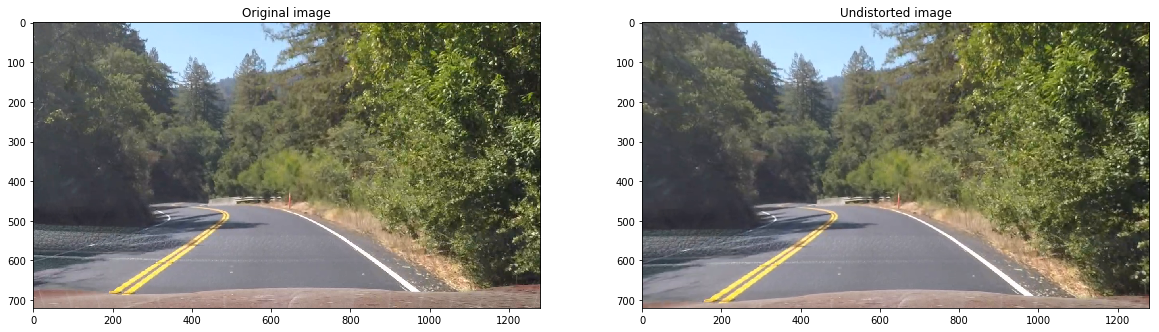

In [3]:
# Testing on an image that wasn't used for calibration
from moviepy.editor import VideoFileClip
from IPython.display import HTML


clip1 = VideoFileClip("./harder_challenge_video.mp4")
img = clip1.get_frame(1) 

ori_img = img

#fname = 'test_images/test2.jpg'
#img = cv2.imread(fname)

undistorted_img = cv2.undistort(img, calibration_mat_2['mtx'], calibration_mat_2['dist'], None, calibration_mat_2['mtx'])

#img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#undistorted_img = cv2.cvtColor(undistorted_img,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20));
plt.subplot(1,2,1)
plt.imshow(img);
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(undistorted_img);
plt.title('Undistorted image')
plt.savefig('examples/undistorted_test2.png', bbox_inches='tight')

 # Step 2:  Use color transforms, gradients or other methods to create a thresholded binary image

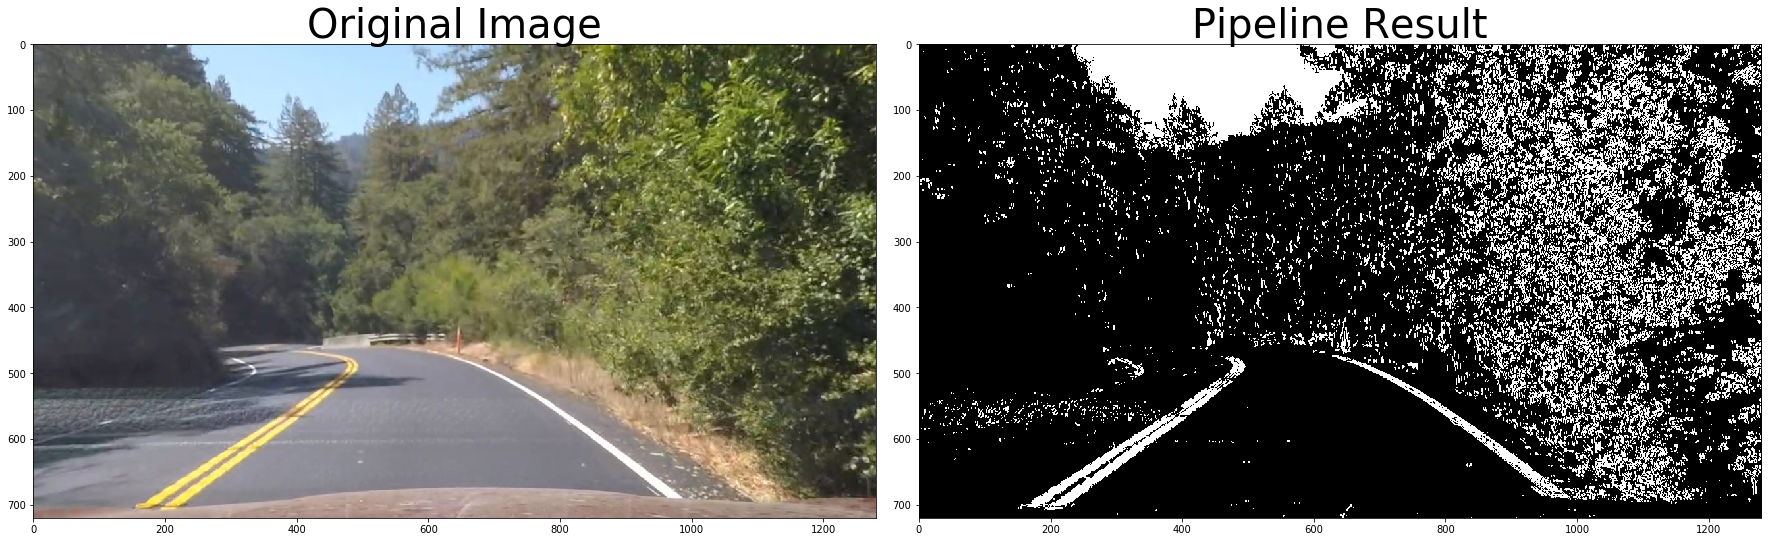

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = undistorted_img

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [6]:
imshape = result.shape
X = imshape[1]
Y = imshape[0]

#Define a region of interest
vertices = np.array([[(0,Y),(0.45*X, 0.55*Y), (0.55*X, 0.55*Y), (X,Y)]], dtype=np.int32)
selected_img = region_of_interest(result, vertices)

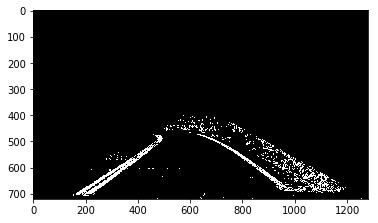

In [7]:
plt.imshow(selected_img, cmap='gray')

# Step 3: Hough transform 

In [27]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for i, line in enumerate(lines):
        slope = get_line_slope(line[0])
        #print(slope)
        if slope<0: color = [0, 255, 0] #left lane
        else: color=[255, 0, 0] #right lane
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness) 

#Compute the slope of a line, useful for differentiate left lane vs. right lane
def get_line_slope(line):
    return (line[1]-line[3])/(line[0]-line[2])

#Due to fixed camera position, lanes mostly have slope ranging in a small range. Use this to filter out
#all spurious lines.
def filter_lines(lines, min_slope=0.55, max_slope=0.85):    
    line_slope = []
    lines2 = []
    for line in lines:
        slope = get_line_slope(line[0])
        if abs(slope) > min_slope and abs(slope) < max_slope:
            line_slope.append(slope)
            lines2.append(line)
    return lines2, line_slope        

#Using linear regression to fit a single line through the collection of lines that mark a lane
def consolidate_lines(lines, max_Y=540):
    line_slope = []
    left_lanes = []
    X = []
    Y = []
    for line in lines:
        left_lanes.append(line)
        X.append(line[0][0])
        X.append(line[0][2])
        Y.append(line[0][1])
        Y.append(line[0][3])
    p = np.polyfit(X, Y, deg=1)
    y0, y1 = 0.65*max_Y, max_Y 
    x0, x1 = round((y0-p[1])/p[0]), round((y1-p[1])/p[0])
    return np.asarray([x0, y0, x1, y1], dtype=int)
        
    
LEFT_LINES = None
RIGHT_LINES = None
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    global LEFT_LINES
    global RIGHT_LINES
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    lines, line_slopes = filter_lines(lines, min_slope=0.4, max_slope=1)
    left_lanes = []
    right_lanes = []
    for i, line in enumerate(lines):
        if line_slopes[i] > 0:
            right_lanes.append(line)
        else:
            left_lanes.append(line)
 
    #consolidate left lanes
    if len(left_lanes)>0:
        left_lines = consolidate_lines(left_lanes, img.shape[0]);
        LEFT_LINES = left_lines
    else: 
        left_lines = LEFT_LINES
        
    #consolidate right lanes
    if len(right_lanes)>0:
        right_lines = consolidate_lines(right_lanes, img.shape[0]);
        LEFT_LINES = right_lines
    else: 
        right_lines = LEFT_LINES
        
    lines = np.stack((left_lines, right_lines), axis=-1)
    lines = np.expand_dims(np.transpose(lines), axis=1)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, [255, 0, 0], 8)
    return line_img, lines


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


# Step 4: Finding lane line


In [28]:
def detect_lanes(image):
    global calibration_mat_2
    
    initial_image = np.copy(image)

    undistorted_img = cv2.undistort(image, calibration_mat_2['mtx'], calibration_mat_2['dist'], None, calibration_mat_2['mtx'])
    edges = pipeline(undistorted_img, s_thresh=(170, 255), sx_thresh=(20, 100))

    imshape = image.shape
    X = imshape[1]
    Y = imshape[0]
    
    #Define a region of interest
    vertices = np.array([[(0,Y),(0.45*X, 0.55*Y), (0.55*X, 0.55*Y), (X,Y)]], dtype=np.int32)
    
    selected_img = region_of_interest(edges, vertices)
    line_img, lines = hough_lines(selected_img, rho=1, 
                       theta=np.pi/180, threshold=40,
                       min_line_len=40, max_line_gap=20)
    final_img = weighted_img(line_img, initial_image, α=0.8, β=1., γ=0.)
    return final_img

In [29]:
final_img = detect_lanes(undistorted_img)

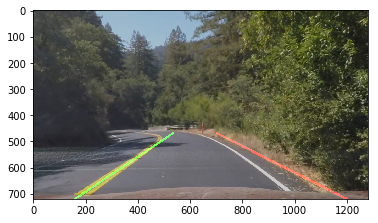

In [30]:
plt.imshow(final_img)

# Step 6: Video

In [31]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = './hough_project_video_proccessed.mp4'
clip1 = VideoFileClip("./project_video_proccessed.mp4")
white_clip = clip1.fl_image(detect_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./hough_project_video_proccessed.mp4
[MoviePy] Writing video ./hough_project_video_proccessed.mp4


100%|█████████▉| 1058/1059 [01:19<00:00, 13.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./hough_project_video_proccessed.mp4 

CPU times: user 2min 28s, sys: 2min 18s, total: 4min 47s
Wall time: 1min 20s


In [32]:
white_output = './hough_challenge_project_video_proccessed.mp4'
clip1 = VideoFileClip("./challenge_video_proccessed.mp4")
white_clip = clip1.fl_image(detect_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./hough_challenge_project_video_proccessed.mp4
[MoviePy] Writing video ./hough_challenge_project_video_proccessed.mp4


100%|██████████| 226/226 [00:23<00:00,  9.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./hough_challenge_project_video_proccessed.mp4 

CPU times: user 37.6 s, sys: 31 s, total: 1min 8s
Wall time: 23.9 s


In [33]:
white_output = './hough_harder_challenge_project_video_proccessed.mp4'
clip1 = VideoFileClip("./harder_challenge_video_proccessed.mp4")
white_clip = clip1.fl_image(detect_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./hough_harder_challenge_project_video_proccessed.mp4
[MoviePy] Writing video ./hough_harder_challenge_project_video_proccessed.mp4


100%|█████████▉| 1199/1200 [02:06<00:00,  9.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./hough_harder_challenge_project_video_proccessed.mp4 

CPU times: user 3min 18s, sys: 2min 37s, total: 5min 55s
Wall time: 2min 6s
